In [ ]:
# Install Vectice
%pip install --q vectice -U

### Instructions

Paste your API token below. (your token can be generated [here](https://app.vectice.com/account/api-keys) )   

Execute the cells.

Based on the Kaggle [Iris project](https://www.kaggle.com/datasets/uciml/iris).

The code shows how to integrate Vectice calls within your Data Science flow in order to do in-time/in-line documentation.    
     
This code is backed by a Vectice project "Simple Project - Hello World", located in the "Samples" worksapce of your Vectice isntance.

In [7]:
# Load libraries
import numpy as np
from datetime import date
from pandas import read_csv, DataFrame
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from vectice import connect, FileResource, Model, Dataset



In [8]:
# Load dataset
url = "https://vectice-examples.s3.us-west-1.amazonaws.com/Samples+Data/iris.csv"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
dataset = read_csv(url, names=names)

In [9]:
## Goal of this sample is to simply catalog assets in Vectice

# Connect to Vectice
conn = connect(
    api_token='YOUR API TOKEN', 
    host='https://app.vectice.com',
    workspace='Samples'
)
# Get a list of available projects
# print(conn.projects)
project = conn.project("Simple Project - Hello World")

Welcome, 'Eric Barre'. You`re now successfully connected to the workspace 'Samples' in Vectice.

To access a specific project, use workspace.project(Project ID)
To get a list of projects you can access and their IDs, use workspace.list_projects()

For quick access to the list of projects in the Vectice web app, visit:
https://app.vectice.com/workspace/projects?w=2110


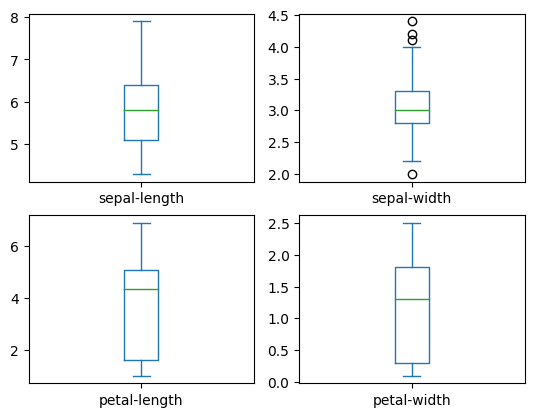

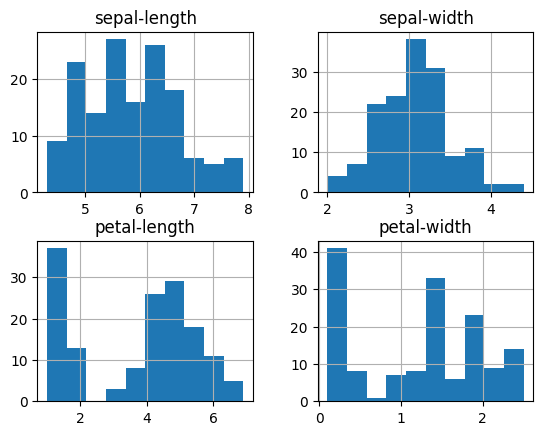

In [10]:
# Plot the dataset
dataset.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
boxplot = pyplot.savefig("boxplot.jpg")
pyplot.show()

# histograms
dataset.hist()
histogram = pyplot.savefig("histogram.jpg")
pyplot.show()

In [11]:
# Capture the origin_dataset in Vectice for documentation
dataset.to_csv("iris.csv")
iris_source = FileResource(path="iris.csv")

# Clean the dataset and materialise it
# Do more data prep/cleaning here
dataset = dataset.fillna(0)
dataset.to_csv("iris_clean.csv")


# Split-out validation dataset
array = dataset.values
Xarray = array[:,0:4]
X = DataFrame(array[:,0:4])
Yarray = array[:,4]
y = DataFrame(array[:,4])

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

# Build Vectice dataset objects
X_train.to_csv("traindataset.csv")
X_validation.to_csv("testdataset.csv")
Y_validation.to_csv("validatedataset.csv")

clean_ds = dataset = Dataset.clean(
    name="Clean Iris Dataset",
    resource=FileResource(path="iris_clean.csv"))


mdl_ds = Dataset.modeling(
    name="Modeling Dataset",
    training_resource=FileResource(path="traindataset.csv"),
    testing_resource=FileResource(path="testdataset.csv"),
    validation_resource=FileResource(path="validatedataset.csv"),
)


File: iris.csv wrapped successfully.
File: iris_clean.csv wrapped successfully.
File: traindataset.csv wrapped successfully.
File: testdataset.csv wrapped successfully.
File: validatedataset.csv wrapped successfully.


### Create an iteration for each model

In [12]:
# Spot Check Algorithms
models = []
models.append(('Logistic Regression', 'LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('Linear Discriminant Analysis', 'LDA', LinearDiscriminantAnalysis()))
models.append(('KNeighbors Classifier', 'KNN', KNeighborsClassifier()))
models.append(('Decision Tree Classifier','CART',  DecisionTreeClassifier()))
models.append(('Gaussian NB', 'NB', GaussianNB()))
models.append(('Support Vector Classifier','SVM', SVC(gamma='auto')))

# evaluate each model in turn
results = []
names = []
labels = []
means = []

for name, label, model in models:
    # Create an iteration for each model defined
    iteration = project.phase("Modeling Techniques").iteration()
    # Document the associated dataset used for this iteration
    iteration.step_collect_datasets = clean_ds
    iteration.step_collect_datasets += mdl_ds

    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    scoring = {'acc': 'accuracy',
            'prec_macro': 'precision_macro',
            'rec_micro': 'recall_macro'}
    cv_results = cross_validate(model, X_train, np.ravel(Y_train), cv=kfold, scoring=scoring)
    results.append(cv_results['test_acc'])
    means.append(np.mean(cv_results['test_acc']))
    labels.append(label)
    names.append(name)
    metrics = {"Accuracy Mean": cv_results['test_acc'].mean(), 
                "Accuracy Std.": cv_results['test_acc'].std(), 
                "Score Time Mean": cv_results['score_time'].mean(),
                "Score Time Std.": cv_results['score_time'].std()}
    # Document model in Vectice - 1 line
    iteration.step_build_model = Model(name= 'Iris Classification Models_' + str(date.today()) , library= name, technique=name, metrics=metrics, attachments=['boxplot.jpg','histogram.jpg'])
    # Commit and close the iteration
    winner = DataFrame({'label':names, 'value': means}).max()
    iteration.step_build_model = "Iteration done\nThe model with the best accuracy mean is " + winner["label"] + ", with a mean accuracy value of: " + str(winner["value"])
    iteration.complete()



Phase 'Modeling Techniques' successfully retrieved.
New Iteration number 2 created.
Iteration number 2 successfully retrieved.
Code captured the following changed files; .gitignore, 23.1/samples/FFBankProject/ProjectModeling.ipynb, 23.1/tutorial/Data_Preparation.ipynb, 23.1/tutorial/Modeling_LR.ipynb
Successfully registered Dataset(name='Clean Iris Dataset', id=24412, version='Version 1', type=CLEAN).
New Dataset: 'Clean Iris Dataset' Version: 'Version 1' added to Step: Collect datasets
Link to Step: https://app.vectice.com/project/phase/iteration?w=2110&iterationId=6344

Iteration number 2 successfully retrieved.
Successfully registered Dataset(name='Modeling Dataset', id=24413, version='Version 1', type=MODELING).
Successfully added Dataset(name='Modeling Dataset', id=24413, version='Version 1', type=MODELING) to Collect datasets
New Model: 'Iris Classification Models_2023-04-30' Version: 'Version 1' added to Step: Build Model
Attachments: boxplot.jpg, histogram.jpg
Link to Step: htt

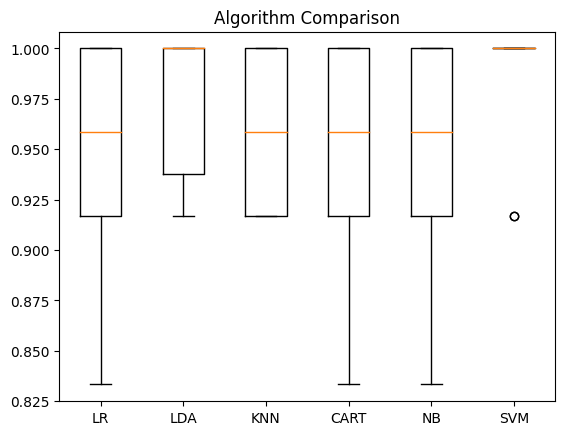

In [13]:
# Compare Algorithms
pyplot.boxplot(results, labels=labels)
pyplot.title('Algorithm Comparison')
pyplot.savefig("algComp.jpg")
pyplot.show()

### Or capture only your milestone

In [14]:
# Based on the plot above it looks like SVM is getting us the most accurate results
# This has already been documented in Vectice in the previous cell when closing the iteration

# Let's get an understanding of the accuracy of our model using our validation dataset

# Make predictions on validation dataset
model = SVC(gamma='auto')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

# Get the next phase in the Vectice project to document my iteration of the SVM model
iteration = project.phase("Model Iterations").iteration()

metrics = {"Mean Accuracy": winner["value"]}
 # Document the associated dataset used for this iteration
iteration.step_fine_tune_model = Model(name= 'Iris Classification Models_' + winner["label"] , 
                                 library= winner["label"], 
                                 technique=winner["label"], 
                                 metrics=metrics, 
                                 attachments=['boxplot.jpg','histogram.jpg'], 
                                 predictor=model,
                                 derived_from=[24400])
iteration.step_fine_tune_model = f"Classification report:\n{classification_report(Y_validation, predictions)}"
iteration.complete()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9666666666666667
[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.86      1.00      0.92         6

       accuracy                           0.97        30
      macro avg       0.95      0.97      0.96        30
   weighted avg       0.97      0.97      0.97        30



New Iteration number 1 created.
Iteration number 1 successfully retrieved.
Model SVC successfully attached to Model(name='Iris Classification Models_Support Vector Classifier', version='Version 1').
New Model: 'Iris Classification Models_Support Vector Classifier' Version: 'Version 1' added to Step: Fine Tune Model
Attachments: boxplot.jpg, histogram.jpg
Link to Step: https://app.vectice.com/project/phase/iteration?w=2110&iterationId=6350



### Fine tune your winning model

In [15]:
# Fine tune the SVM model and check for improvement
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

param_grid = {'C':[0.1,1,10,100], 'gamma':[1,0.1,0.01,0.001]}
scoring = {
 'accuracy_score': make_scorer(accuracy_score)
}
grid = GridSearchCV(SVC(), param_grid, refit = 'accuracy_score', verbose=0)
grid.fit(X_train, np.ravel(Y_train))

pred_grid = grid.predict(X_validation)
tunedAccScore  = accuracy_score(Y_validation, pred_grid)
# Evaluate predictions
print(accuracy_score(Y_validation, pred_grid))
print(confusion_matrix(Y_validation, pred_grid))
print(classification_report(Y_validation, pred_grid))

0.9666666666666667
[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.86      1.00      0.92         6

       accuracy                           0.97        30
      macro avg       0.95      0.97      0.96        30
   weighted avg       0.97      0.97      0.97        30



### Build Vectice Documentation Pipeline

In [16]:
# Document findings in Vectice
message = ""
mod = "base"
if winner["value"] > tunedAccScore:
    message = "The tuned model is less accurate than our base model."
elif winner == tunedAccScore:
    message = "The tuned model performs the same as the base model."
else:
    message = "The tuned model shows a relevant improvement over the base model."
    mod = "tuned"
message += "\nModel name: " + winner["label"] + "\nParameter grid:" + str(param_grid) + "\nBase model accuracy score:" + str(winner["value"]) + "\nTuned model accuracy score: " + str(tunedAccScore)
message += "\n\nRecommend deploying the {e} model." .format(e=mod)
iteration = project.phase("Model Iterations").iteration()

metrics = {"Mean Accuracy": tunedAccScore}
iteration.step_fine_tune_model = mdl_ds
iteration.step_fine_tune_model = Model(name= 'Iris Classification Models_' + winner["label"] , 
                                 library= winner["label"], 
                                 technique=winner["label"], 
                                 metrics=metrics, 
                                 attachments=['boxplot.jpg','histogram.jpg'], 
                                 properties=param_grid,
                                 predictor=model)
iteration.step_fine_tune_model = message
iteration.complete()

New Iteration number 2 created.
Iteration number 2 successfully retrieved.
Successfully registered Dataset(name='Modeling Dataset', id=24413, version='Version 1', type=MODELING).
Existing Dataset: 'Modeling Dataset' Version: 'Version 1' added to Step: Fine Tune Model
Link to Step: https://app.vectice.com/project/phase/iteration?w=2110&iterationId=6351

Model SVC successfully attached to Model(name='Iris Classification Models_Support Vector Classifier', version='Version 2').
Existing Model: 'Iris Classification Models_Support Vector Classifier' Version: 'Version 2' added to Step: Fine Tune Model
Attachments: boxplot.jpg, histogram.jpg
Link to Step: https://app.vectice.com/project/phase/iteration?w=2110&iterationId=6351



### End of sample